## Tutorial 4: Scenario database

In this tutorial, we will cover the following items:

NOTE: This tutorial is not yet finished.

In [1]:
# Before starting, let us do the necessary imports
import os
import matplotlib.pyplot as plt
import numpy as np
from domain_model import DocumentManagement, StateVariable

## 1. Loading and saving the database

A real-life application of the object-oriented framework is the scenario database of [TNO's StreetWise](https://www.tno.nl/en/focus-areas/traffic-transport/expertise-groups/research-on-integrated-vehicle-safety/scenario-based-safety-validation-for-connected-and-automated-driving/). The code contains a class that is used to interface with the database. This class (`DocumentManagement`) can also be used to interact in a similar fashion with a locally stored database. This is practical if the local database is not too large. 

In this tutorial, we will use `DocumentManagement` using a locally stored set of scenarios in which the leading vehicle is decelerating. Loading a "database" from a locally stored file is straightforward. When passing a file path when creating an object from the `DocumentManagement` class, the file is loaded.

In [2]:
DM = DocumentManagement(os.path.join("examples", "lvd_scenarios.json"))

The JSON code of all objects are now contained by `DM`. More specifically, `DM.collections` contains dictionaries of all objects. For example, `DM.collections["scenario"]` contains all scenarios. This dictionary, which consists for (key, value) pairs, uses the scenario IDs as "keys" and the JSON code of the scenario as "value".

Using `DM.collections`, we can see how much data we have:

In [3]:
print("We have:")
print("{:d} scenarios,".format(len(DM.collections["scenario"])))
print("{:d} activity categories,".format(len(DM.collections["activity_category"])))
print("{:d} activities,".format(len(DM.collections["activity"])))
print("{:d} events,".format(len(DM.collections["event"])))
print("{:d} actor categories,".format(len(DM.collections["actor_category"])))
print("{:d} actors,".format(len(DM.collections["actor"])))
print("{:d} physical element categories,".format(len(DM.collections["physical_element_category"])))
print("{:d} physical elements, and".format(len(DM.collections["physical_element"])))
print("{:d} models.".format(len(DM.collections["model"])))

We have:
1149 scenarios,
7 activity categories,
5271 activities,
12165 events,
2 actor categories,
1150 actors,
1 physical element categories,
1 physical elements, and
2 models.


Saving all objects is also straightforward. Use the `to_json` function to store the "database" into a JSON file.

In [4]:
DM.to_json(os.path.join("examples", "lvd_scenarios2.json"))

## 2. Obtaining objects from the database

The `DM` contains all JSON codes of the objects, but what we actually want is to have all objects. To retrieve an actual object, the `get_item` function is used. It takes two arguments:

- The type of object you want (specified using a string, e.g., `"scenario"` or `"actor"`)
- The key value, i.e., the ID of the object.

For example, let us retrieve the first scenario in the database:

In [5]:
key = list(DM.collections["scenario"].keys())[0]
scenario1 = DM.get_item("scenario", key)

Now `scenario1` is a `Scenario` object. All of its attributes are automatically instantiated using `get_item`. For example, here are the actors:

In [6]:
for actor in scenario1.actors:
    print("{:s}: {}".format(actor.name, actor))

ego vehicle: <domain_model.actor.Actor object at 0x0000000028058390>
target vehicle: <domain_model.actor.Actor object at 0x0000000028058400>


When using `get_item` to retrieve an object that has already been instantiated, then the object that has been instantiated is returned instead. This is desired, because otherwise two objects of the same, e.g., actor, is returned. To see what we mean, let's look at the following example:

In [7]:
key = list(DM.collections["scenario"].keys())[1]
scenario2 = DM.get_item("scenario", key)

In [8]:
for actor in scenario2.actors:
    print("{:s}: {}".format(actor.name, actor))

ego vehicle: <domain_model.actor.Actor object at 0x0000000028058390>
target vehicle: <domain_model.actor.Actor object at 0x0000000028062320>


This is a different scenario, but one actor is the same as for the first scenario (the ego vehicle). When having a close look at the pointer's address, we can see that the ego vehicle of the second scenario is actually the same object as for the first scenario. The target vehicle, however, is a different object this time.

## 3. Deleting an object from the database

Deleting an item from the database can be done using the `delete_item` function. It uses the same arguments as the `get_item` function.

In [9]:
DM.delete_item("scenario", scenario1.uid)

In [10]:
scenario1.uid in DM.collections["scenario"]

False

As shown above, the ID of the deleted scenario is not found anymore in the collections. Note, however, that the attribute objects of the scenario are not deleted from the database. For example, the actor is still in the database:

In [11]:
scenario1.actors[0].uid in DM.collections["actor"]

True

For demonstrating another functionality, let us also delete the target vehicle of the first scenario:

In [12]:
DM.delete_item("actor", scenario1.actors[1].uid)

## 4. Add item to the database

To add an object to the database, use the `add_item` function with as only argument the object that has to be added to the database. For example, we can add the deleted scenario to the database.

In [13]:
DM.add_item(scenario1)

Note, however, that when trying to retrieve this scenario that we just added, an error will occur:

In [14]:
try:
    scenario3 = DM.get_item("scenario", scenario1.uid)
except KeyError as e:
    print("Key not found: {}".format(e))
print("ID of actor that we deleted: {:d}".format(scenario1.actors[1].uid))

Key not found: 210012260450476655720478580346655076981
ID of actor that we deleted: 210012260450476655720478580346655076981


What happened here? While we are trying to retrieve the scenario, the `get_item` function automatically tries to retrieve the attribute objects of the scenario. However, it fails to retrieve the target vehicle, because that object has not been added to the database after we deleted it. In other words, by default, only the object that is passed to `add_item` is stored in the database, while its attribute objects are not stored.

In order to also store the attributes, add `include_atributes=True` to the function call:

In [15]:
DM.add_item(scenario1, include_attributes=True)

In [16]:
scenario3 = DM.get_item("scenario", scenario1.uid)

Now there is no error when retrieving the scenario from the database.

## 5. Looping through all scenarios

In the following example, we demonstrate how to loop through all scenarios. In principle, the same can be done with the other objects.

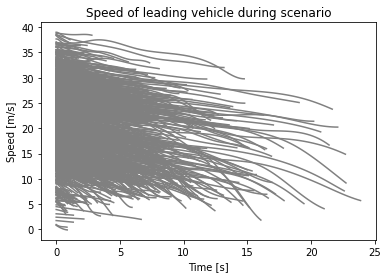

In [17]:
for key in DM.collections["scenario"]:
    scenario = DM.get_item("scenario", key)
    
    # To get the speed, we need:
    # 1. The right actor, which is always the second (index=1) actor of the scenario.
    # 2. Select the right state variable (StateVariable.LON_TARGET).
    # 3. Select the right time window.
    # Note: StateVariable.LON_TARGET contains two variables: speed and distance (hence the "[:, 0]").
    time = np.linspace(scenario.get_tstart(), scenario.get_tend(), 100)
    leading_speed = scenario.get_state(scenario.actors[1], StateVariable.LON_TARGET, time)[:, 0]
    
    plt.plot(time-scenario.get_tstart(), leading_speed, color=(.5, .5, .5))
    
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
_ = plt.title("Speed of leading vehicle during scenario")

You reached the end of the fourth and final tutorial. We hope it has been useful! If you have any questions/requests, please contact us.